# Forward Modeling the X-ray Image data

In this notebook, we'll take a closer look at the X-ray image data products, and build a simple, generative, *forward model* for the observed data.

In [1]:
from __future__ import print_function
import astropy.io.fits as pyfits
import astropy.visualization as viz
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

## The XMM Image Data

* Recall that we downloaded some XMM data in the ["First Look"](./FirstLook.ipynb) notebook. 


* We downloaded three files, and just looked at one - the "science" image.

In [2]:
imfits = pyfits.open('a1835_xmm/P0098010101M2U009IMAGE_3000.FTZ')
im = imfits[0].data

* `im` is the image, our observed data, presented after some "standard processing." The numbers in the pixels are *counts* (i.e. numbers of photoelectrons recorded by the CCD during the exposure).  


* We display the image on a log scale, which allows us to simultaneously see both the cluster of galaxies in the center, and the much fainter background and other sources in the field.

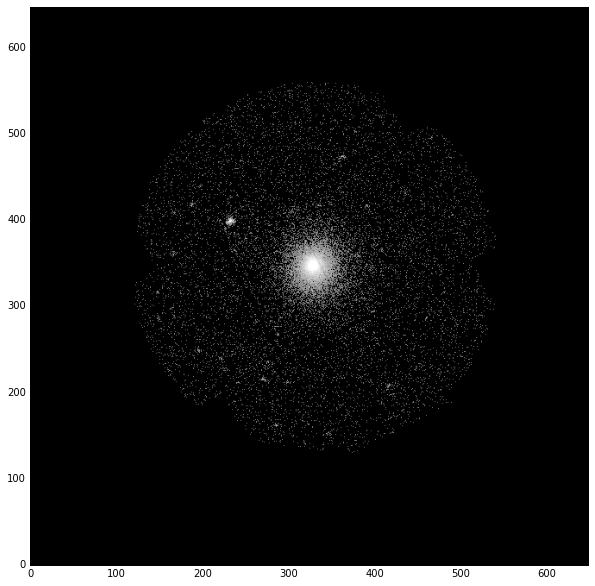

In [3]:
plt.imshow(viz.scale_image(im, scale='log', max_cut=40), cmap='gray', origin='lower');

## A Model for the Cluster of Galaxies


* We will use a common *parametric model* for the surface brightness of galaxy clusters: the azimuthally symmetric beta model:

$S(r) = S_0 \left[1.0 + \left(\frac{r}{r_c}\right)^2\right]^{-3\beta + 1/2}$,

   where $r$ is projected distance from the cluster center. 


* The parameters of this model are:

   0. $x_0$, the $x$ coordinate of the cluster center
   1. $y_0$, the $y$ coordinate of the cluster center
   2. $S_0$, the normalization, in surface brightness units
   3. $r_c$, a radial scale (called the "core radius")
   4. $\beta$, which determines the slope of the profile


* Note that this model describes a 2D surface brightness distribution, since $r^2 = x^2 + y^2$


* **Let's draw a cartoon of this model on the whiteboard**

## Planning an Expected Counts Map

* Our data are *counts*, i.e. the number of times a physical pixel in the camera was activated while pointing at the area of sky corresponding to a pixel in our image. We can think of different sky pixels as having different effective exposure times, as encoded by an *exposure map,* `ex`. 


* We *expect* to see counts due to a number of sources:

  1. X-rays from the galaxy cluster
  2. X-rays from other detected sources in the field
  3. X-rays from *unresolved* sources (the Cosmic X-ray Background)
  4. Diffuse X-rays from the Galactic halo and the local bubble (the local X-ray foreground)
  5. Soft protons from the solar wind, cosmic rays, and other undesirables (the particle background)
  
  
Let's go through these in turn.

### 1. Counts from the Cluster

* Since our data are counts in each pixel, our model needs to first predict the *expected* counts in each pixel. Physical models predict *intensity* (counts per second per pixel per unit effective area of the telescope). The spatial variation of the effective area relative to the aimpoint is one of the things accounted for in the exposure map, and we can leave the overall area to one side when fitting (although we would need it to turn our results into physically interesting conclusions about, e.g. the luminosity of the cluster).


* Since the X-rays from the cluster are transformed according to the exposure map, the units of $S_0$ are counts/s/pixel, and the model prediction for the *expected number* of counts from the cluster is `CL*ex`, where `CL` is an image with pixel values computed from $S(r)$.



### 2-4. X-ray background model

* The X-ray background will be "vignetted" in the same way as X-rays from the cluster. We can lump sources 2-4 together, to extend our model so that it is composed of a galaxy cluster, plus an X-ray background.


* The simplest assumption we can make about the X-ray background is that it is spatially uniform, on average. The model must account for the varying effective exposure as a function of position, however. So the model prediction associated with this component is `b*ex`, where `b` is a single number with units of counts/s/pixel.


* We can circumvent the problem of the other detected sources in the field by *masking them out*, leaving us with the assumption that *any remaining counts are not due to the masked sources*. This could be a source of systematic error, so we'll note it down for later.


### 5. Particle background model


* The particle background represents a flux of particles that either do not traverse the telescope optics at all, or follow a different optical path than X-rays - so the exposure map (and its vignetting correction) does not apply. 


* Instead, we're given, from a black box, a prediction for the expected counts/pixel due to particles, so the extension to our model is simply to add this image, `pb`.


### Full model

* Combining these three components, the model `(CL+b)*ex + pb` gives us an *expected number of counts/pixel across the field.*

## A Look at the Other XMM Products

* The "exposure map" and the "particle background map" were supplied to us by the XMM reduction pipeline, along with the science image. Let's take a look at them now.

In [4]:
pbfits = pyfits.open('a1835_xmm/P0098010101M2X000BKGMAP3000.FTZ')
pb = pbfits[0].data
exfits = pyfits.open('a1835_xmm/P0098010101M2U009EXPMAP3000.FTZ')
ex = exfits[0].data

###  The "Exposure Map"

* The `ex` image is  in units of seconds, and represents the effective exposure time at each pixel position. 


* This is actually the product of the exposure time that the detector was exposed for, and a relative *sensitivity* map accounting for the vignetting of the telescope, dithering, and bad pixels whose data have been excised. 


* Displaying the exposure map on a linear scale makes the vignetting pattern and other features clear.

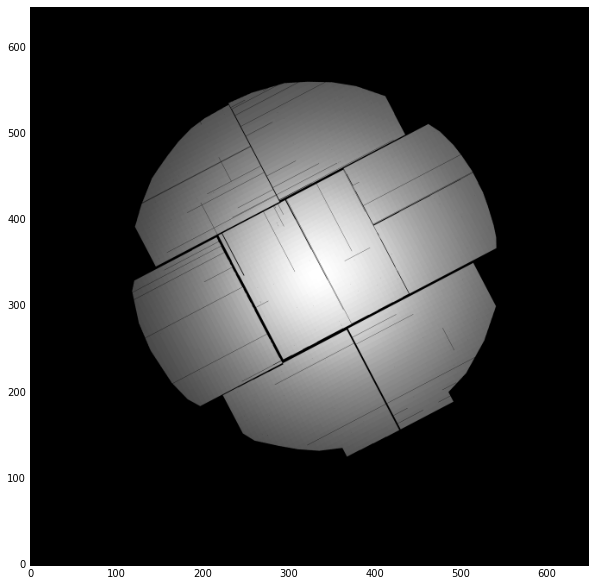

In [5]:
plt.imshow(ex, cmap='gray', origin='lower');
plt.savefig("figures/cluster_expmap.png")

### The "Particle Background Map"

* `pb` is not data at all, but rather a model for the expected counts/pixel *in this specific observation* due to the "quiescent particle background."


* This map comes out of a blackbox in the processing pipeline.  Even though there are surely uncertainties in it, we have no quantitative description of them to work with. 


* Note that the exposure map above does *not* apply to the particle backround; some particles are vignetted by the telescope optics, but not to the same degree as X-rays. The resulting spatial pattern and the total exposure time are accounted for in `pb`.

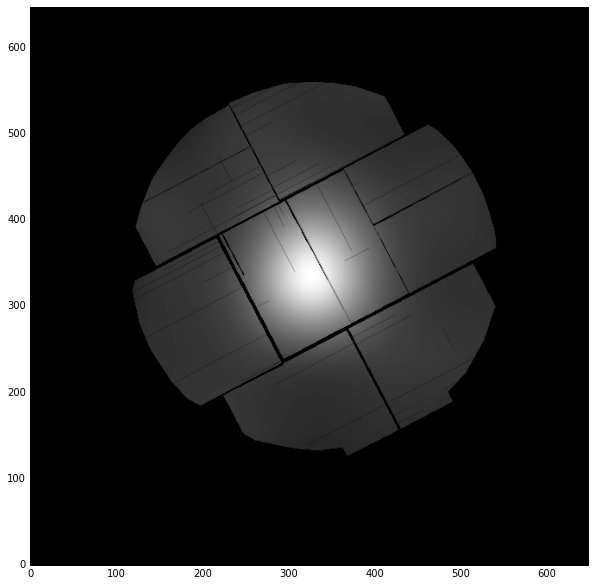

In [6]:
plt.imshow(pb, cmap='gray', origin='lower');
plt.savefig("figures/cluster_pbmap.png")

### Masking out the other sources

* There are non-cluster sources in this field. To simplify the model-building exercise, we will crudely mask them out for the moment. 


* A convenient way to do this is by setting the exposure map to zero in these locations - as if a set of tiny little shutters in front of each of those pixels had not been opened. "Not observed" is different from "observed zero counts."


* Let's read in a text file encoding a list of circular regions in the image, and set the exposure map pixels within each of those regions in to zero.

In [7]:
mask = np.loadtxt('a1835_xmm/M2ptsrc.txt')
for reg in mask:
    # this is inefficient but effective
    for i in np.round(reg[1]+np.arange(-np.ceil(reg[2]),np.ceil(reg[2]))):
        for j in np.round(reg[0]+np.arange(-np.ceil(reg[2]),np.ceil(reg[2]))):
            if (i-reg[1])**2 + (j-reg[0])**2 <= reg[2]**2:
                ex[np.int(i-1), np.int(j-1)] = 0.0

* As a sanity check, let's have a look at the modified exposure map. 


* Compare the location of the "holes" to the science image above.

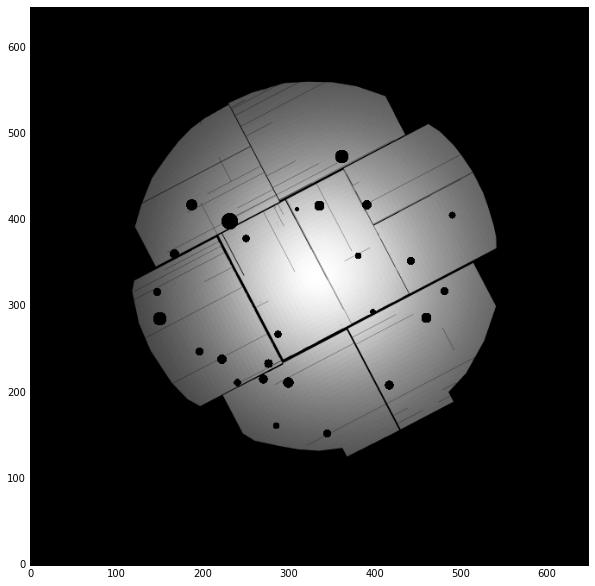

In [8]:
plt.imshow(ex, cmap='gray', origin='lower');
plt.savefig("figures/cluster_expmap_masked.png")

# A Generative Model for the X-ray Image

* All of the discussion above was in terms of predicting the *expected number of counts in each pixel,* $\mu_k$. This is not what we observe: we observe *counts*.


* To be able to generate a mock dataset, we need to make an assumption about the form of the *sampling distribution* for the counts $N$ in each pixel, ${\rm Pr}(N_k|\mu_k)$.


* Let's assume that this distribution is *Poisson*, since we expect X-ray photon arrivals to be "rare events."

${\rm Pr}(N_k|\mu_k) = \frac{{\rm e}^{-\mu_k} \mu_k^{N_k}}{N_k !}$


* Here, $\mu_k(\theta)$ is the expected number of counts in the $k$th pixel:

$\mu_k(\theta) = \left( S(r_k;\theta) + b \right) \cdot$ ex + pb


* Note that writing the sampling distribution like this contains the assumption that *the pixels are independent* (i.e., there is no cross-talk between the cuboids of silicon that make up the pixels in the CCD chip). (Also note that this assumption is different from the assumption that the *expected numbers of counts* are independent! They are explicitly *not* independent: we wrote down a model for a cluster surface brightness distribution that is potentially many pixels in diameter.)

* At this point we can draw the PGM for a *forward model* of this dataset, using the exposure and particle background maps supplied, and some choices for the model parameters.


* Then, we can go ahead and simulate some mock data and compare with the image we have.

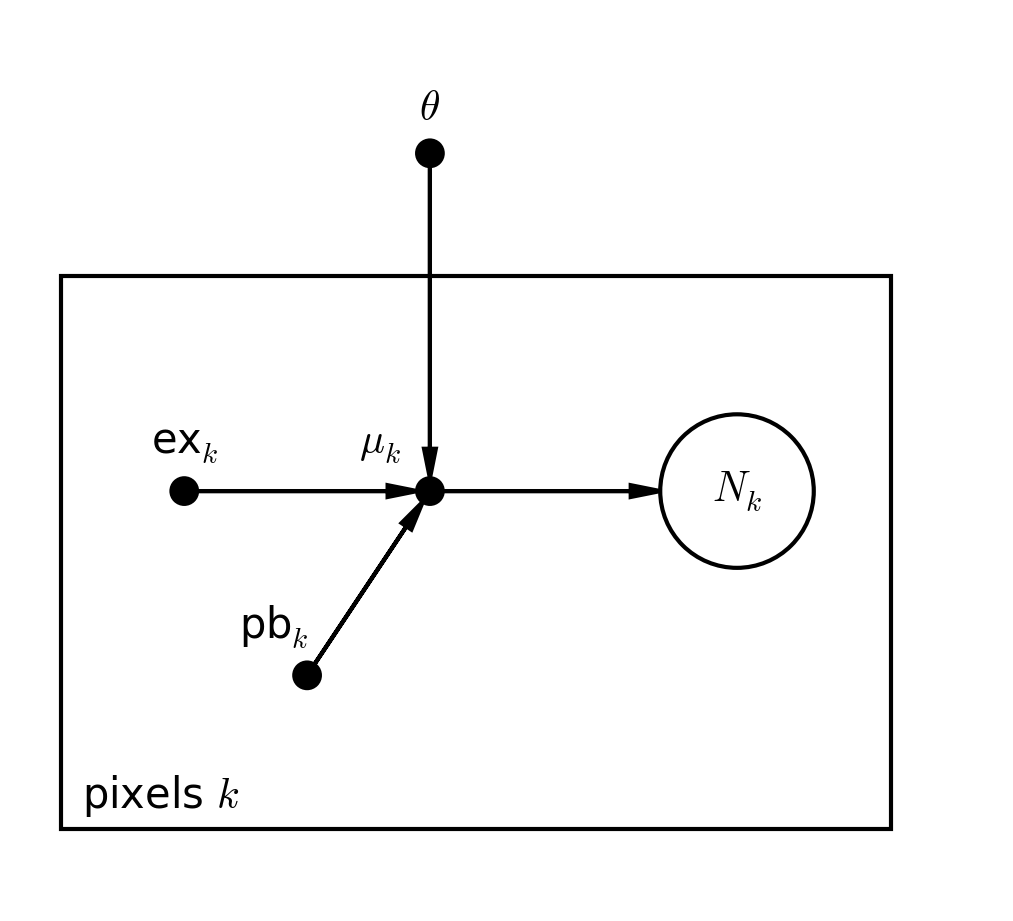

In [9]:
# import cluster_pgm
# cluster_pgm.forward()

from IPython.display import Image
Image(filename="cluster_pgm_forward.png")

In [10]:
def beta_model_profile(r, S0, rc, beta):
    '''
    The fabled beta model, radial profile S(r)
    '''
    return S0 * (1.0 + (r/rc)**2)**(-3.0*beta + 0.5)

def beta_model_image(x, y, x0, y0, S0, rc, beta):
    '''
    Here, x and y are arrays ("meshgrids" or "ramps") containing x and y pixel numbers, 
    and the other arguments are galaxy cluster beta model parameters.
    Returns a surface brightness image of the same shape as x and y.
    '''
    r = np.sqrt((x-x0)**2 + (y-y0)**2)
    return beta_model_profile(r, S0, rc, beta)

def model_image(x, y, ex, pb, x0, y0, S0, rc, beta, b):
    '''
    Here, x, y, ex and pb are images, all of the same shape, and the other args are 
    cluster model and X-ray background parameters. ex is the (constant) exposure map
    and pb is the (constant) particle background map.
    '''
    return (beta_model_image(x, y, x0, y0, S0, rc, beta) + b) * ex + pb

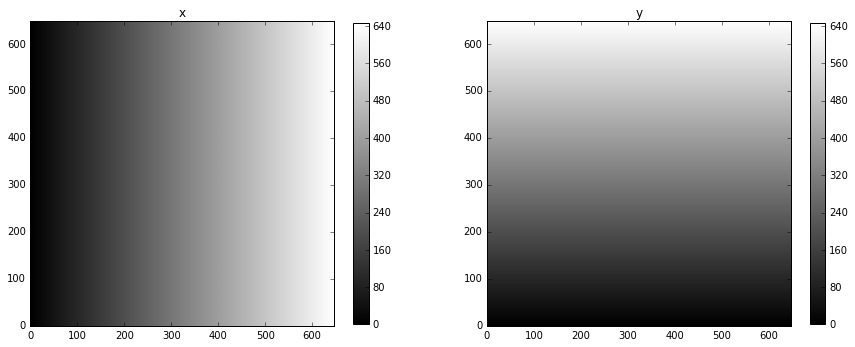

In [11]:
# Set up the ramp images, to enable fast array calculations:

nx,ny = ex.shape
x = np.outer(np.ones(ny),np.arange(nx))
y = np.outer(np.arange(ny),np.ones(nx))

fig,ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)
left = ax[0].imshow(x, cmap='gray', origin='lower')
ax[0].set_title('x')
fig.colorbar(left,ax=ax[0],shrink=0.9)
right = ax[1].imshow(y, cmap='gray', origin='lower')
ax[1].set_title('y')
fig.colorbar(right,ax=ax[1],shrink=0.9)

In [12]:
# Now choose parameters, compute model and plot, compared to data!

x0,y0 = 328,348    # The center of the image is 328,328
S0,b = 0.01,5e-7  # Cluster and background surface brightness, arbitrary units
beta = 2.0/3.0     # Canonical value is beta = 2/3
rc = 4            # Core radius, in pixels

# Realize the expected counts map for the model:
mu = model_image(x,y,ex,pb,x0,y0,S0,rc,beta,b)

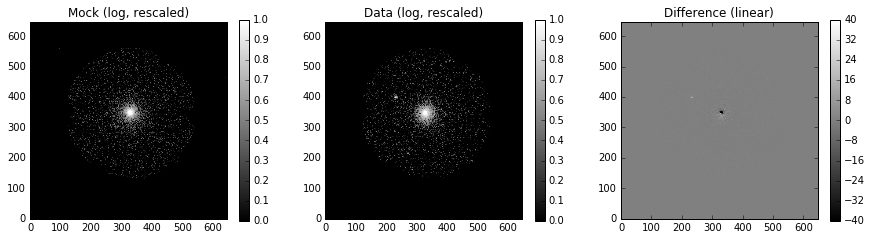

In [14]:
# Draw a *sample image* from the Poisson sampling distribution:
mock = np.random.poisson(mu,mu.shape)

# The difference between the mock and the real data should be symmetrical noise if the model
# is a good match...
diff = im - mock


# Plot three panels:

fig,ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 6)
plt.subplots_adjust(wspace=0.2)

left = ax[0].imshow(viz.scale_image(mock, scale='log', max_cut=40), cmap='gray', origin='lower')
ax[0].set_title('Mock (log, rescaled)')
fig.colorbar(left,ax=ax[0],shrink=0.6)

center = ax[1].imshow(viz.scale_image(im, scale='log', max_cut=40), cmap='gray', origin='lower')
ax[1].set_title('Data (log, rescaled)')
fig.colorbar(center,ax=ax[1],shrink=0.6)

right = ax[2].imshow(diff, vmin=-40, vmax=40, cmap='gray', origin='lower')
ax[2].set_title('Difference (linear)')
fig.colorbar(right,ax=ax[2],shrink=0.6)

fig.savefig("figures/cluster_mock-data-diff.png")

### Exercise: Adjust the model parameters and generate a mock that matches the data

If you are not following in your own notebook, you'll need to sit close to someone who is running it. 